### Extract glider section from LLC4320 

In [11]:
import xarray as xr
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

In [2]:
ds = xr.open_dataset('LLC4320_pre-SWOT_ACC_SMST_20111221.nc')

There are two tasks that need to be dealt with here: 
- LLC4320 data does not have lat-lon etc as a coordinate, instead the coordinates are simply index numbers. This means that the lon-lat-depth passed for the trajectory have to be converted to the corresponding index numbers first (which will not be integers). (This is annoying!)
- These interpolated "index numbers" will then be used to extract data on points. 

In [119]:
# Change coordinate of time to make life easier
ds = ds.assign_coords(time=np.linspace(1,24, num=24))

#### Coordinates to "index numbers"


In [6]:
# try for Z first as that 1d. 

z = ds.Z
k = ds.k

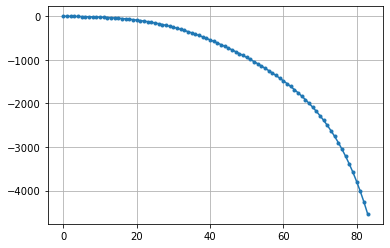

In [16]:
plt.plot(k, z, '.-')
plt.grid()

In [14]:
f_z = interpolate.interp1d(z, k)

In [26]:
X = ds.XC
Y = ds.YC

In [36]:
i = ds.i
j = ds.j

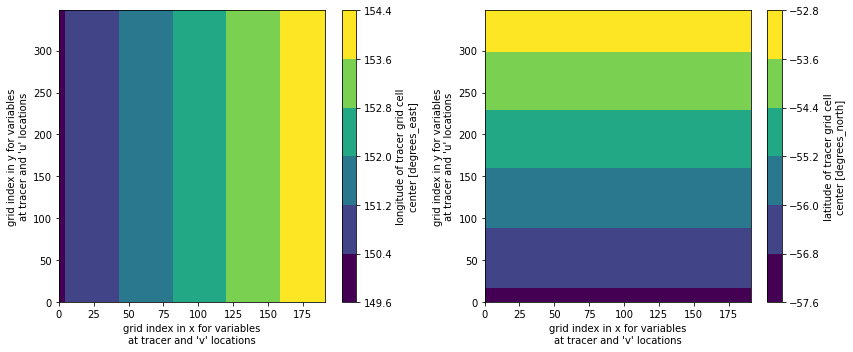

In [30]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
X.plot.contourf()

plt.subplot(122)
Y.plot.contourf()

plt.tight_layout()

It seems like (atleast for this region) the LLC grids are linear, meaning that every i value has only one X associated with. This implies that the grid is not curved relative to i and j. This makes life much easier.

In [38]:
f_x = interpolate.interp1d(X[0,:].values, i)
f_y = interpolate.interp1d(Y[:,0].values, j)

Now that we have the required functions to go from lon, lat, z to the indices i,j,k, we can move forward. 

### Interpolate to the track

In [65]:
print(X.min(), X.max())
print(Y.min(), Y.max())

<xarray.DataArray 'XC' ()>
array(150.30207825) <xarray.DataArray 'XC' ()>
array(154.28125)
<xarray.DataArray 'YC' ()>
array(-56.98995209) <xarray.DataArray 'YC' ()>
array(-53.00566864)


[Text(0, 0.5, 'lat')]

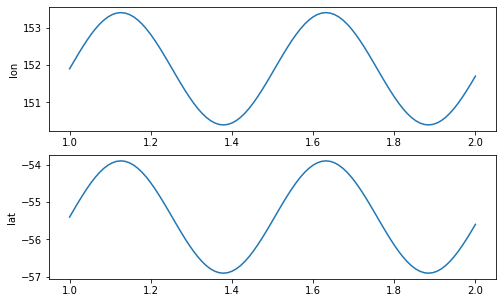

In [122]:
# 150 to 154
# -57 to -53

n = 4*ds.time.size # number of time points
ncycle = 2 # number of crossings
A = 3 # amplitude of the crossings

# create survey data
survey = xr.Dataset(
    dict(
        lon = xr.DataArray(A*(np.sin(2*np.pi*np.arange(n)/(n/ncycle))+1)/2 + 150.4,dims='points'),
        lat = xr.DataArray(A*(np.sin(2*np.pi*np.arange(n)/(n/ncycle))+1)/2 - 56.9,dims='points'),
        time = xr.DataArray(np.linspace(ds.time[0], ds.time[1], num=n),dims='points'),
    )
)

# plot survey lon and lat with time
fig,ax = plt.subplots(2,1,figsize=(8,5))
ax[0].plot(survey.time,survey.lon)
ax[1].plot(survey.time,survey.lat)
ax[0].set(ylabel='lon')
ax[1].set(ylabel='lat')


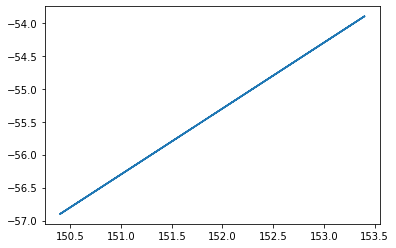

In [123]:
plt.plot(survey.lon, survey.lat)

In [125]:
survey_indices= xr.Dataset(
    dict(
        i = xr.DataArray(f_x(survey.lon), dims='points'),
        j = xr.DataArray(f_y(survey.lat), dims='points'),
        k = xr.DataArray(0*np.zeros_like(survey.lon.data), dims='points'),
        time = xr.DataArray(np.linspace(ds.time[0], ds.time[1], num=n),dims='points'),
    )
)

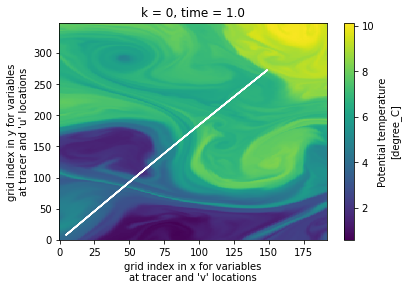

In [127]:
ds.Theta.isel(k=0, time=0).plot()
plt.plot(survey_indices.i, survey_indices.j, color='w')

In [128]:
theta_points = ds.Theta.interp(survey_indices)

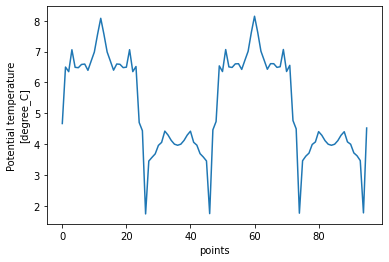

In [129]:
theta_points.plot()